# Real Estate Listing Promotion Strategy

This project simulates a real-world data analysis scenario for Nova Holdings, a leading real estate agency in the US managing tens of thousands of listings annually. As a Data Analyst, the goal was to develop a data-driven promotional strategy for showcasing 1,000 property listings on Zillow—America’s top real estate platform—out of a total inventory of 10,000 listings set to be sold in the upcoming six months.

Key Analytical Questions:
- Top 10 Sought-After Locations, based on search patterns and consumer demand.
- Top 10 Locations for Investment, based on profitability, growth trends, and relative value.
- Zillow Slot Allocation Strategy:

a. Prioritize listings based on search interest, consumer leads, and property value. Select the top 50 listings to promote, justifying their inclusion.

b. Define de-prioritization criteria for when a listing should be removed from promotion.

## Step 1: Load the data

Loaded data from all three sheets and created copies of it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

xls = pd.ExcelFile("dataset.xlsx")

traffic_df = xls.parse("traffic")
leads_df = xls.parse("leads")
inventory_df = xls.parse("inventory")

traffic = traffic_df.copy()
leads = leads_df.copy()
inventory = inventory_df.copy()

## Step 2: Clean the data

In [2]:
traffic.drop_duplicates(inplace=True)
leads.drop_duplicates(inplace=True)

## Step 3: Create a unified 'Location' column
Created a unified Location column from City, Neighborhood, and Section for joining and analysis. At the same time, handled the missing Neighborhood and Section values.

In [3]:
for df in [traffic, leads, inventory]:
    df['Neighborhood'] = df['Neighborhood'].fillna('')
    df['Section'] = df['Section'].fillna('')
    df['Location'] = df['City'] + ', ' + df['Neighborhood'] + ', ' + df['Section']
    df['Location'] = df['Location'].str.replace(', ,', ',').str.strip(', ')

## Task 1a: Top 10 most searched locations
Compute the total searches per Location. The cell agregates the total searches for each Location, sorts them in descending order
and picks the top 10.

In [4]:
location_searches = traffic.groupby('Location')['Searches'].sum()
top_10_locations = location_searches.sort_values(ascending=False).head(10)
print("Top 10 most searched locations:")
print(top_10_locations)

Top 10 most searched locations:
Location
New York        10024
Los Angeles      9004
Chicago          5289
Miami            5036
Houston          4478
Dallas           4204
Philadelphia     3409
Atlanta          3268
Boston           2634
Detroit          2246
Name: Searches, dtype: int64


### Plot for the top 10 Most Searched Locations

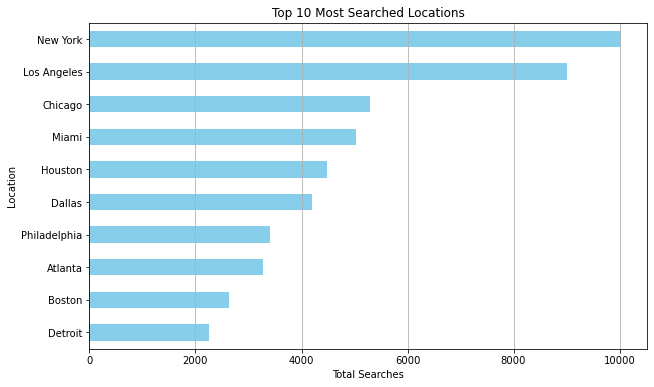

In [5]:
plt.figure(figsize=(10,6))
top_10_locations.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Searched Locations')
plt.xlabel('Total Searches')
plt.ylabel('Location')
plt.grid(axis='x')
plt.show()

## Task 1b: Normalize searches by Inventory Count

I also computed the search demand per listing to identify locations where each listing receives the highest attention from users. This helped ensure that we do not just focus on total volume, but also on efficiency of promotion slot usage.

First, we count the number of listings per Location, then get the total searches per Location. After that we merge the data frames and compute the normalized value. The normalized seach is computed by the sum of all user searches associated with that location devided by the number of properties in the inventory that belong to that location. We pick the top 10 results.

In [6]:
listing_count = inventory.groupby('Location')['Listing iD'].count().reset_index()
listing_count.rename(columns={'Listing iD': 'Listing_Count'}, inplace=True)

total_searches = traffic.groupby('Location')['Searches'].sum().reset_index()

searches_normalized = total_searches.merge(listing_count, on='Location', how='left')

searches_normalized['Searches_per_Listing'] = (searches_normalized['Searches'] / searches_normalized['Listing_Count']).round(2)

top_normalized = searches_normalized.sort_values(by='Searches_per_Listing', ascending=False).head(10)
print(top_normalized[['Location', 'Searches_per_Listing']])

           Location  Searches_per_Listing
1396       New York               5012.00
777         Houston               4478.00
488          Dallas               4204.00
1737      Riverside               1843.00
312         Chicago               1322.25
2072          Tampa               1009.00
1019    Los Angeles               1000.44
577          Denver                973.50
867    Indianapolis                860.50
1865  San Francisco                686.33


### Plot Normalize searches by Inventory Count

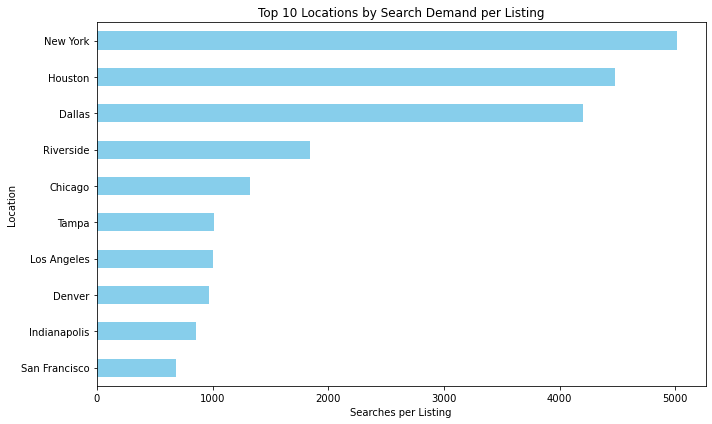

In [7]:
top_normalized.set_index('Location')['Searches_per_Listing'].plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.xlabel("Searches per Listing")
plt.title("Top 10 Locations by Search Demand per Listing")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Task 2: Top 10 investment opportunities

First, we filter the data for-sales listisgs. After that we compute the average price per Location and sum the toal leads per Location. We merge the data and compute the investment score. The investment score is calcultates as:

Investment Score = Total Leads per Location / (Average Price per Location / 100,000)

This gives you the number of leads generated per $100K of price. Finally, we format the results and display the top 10 investment locations. 

In [8]:
inventory_sale = inventory[inventory["Purpose"] == "for-sale"]
leads_sale = leads[leads["Purpose"] == "for-sale"]

avg_price_by_location = inventory_sale.groupby("Location")["Price"].mean().reset_index()

leads_by_location = leads_sale.groupby("Location")["Leads"].sum().reset_index()

investment_df = pd.merge(avg_price_by_location, leads_by_location, on="Location")

investment_df["Investment Score"] = investment_df["Leads"] / (investment_df["Price"] / 100000)

investment_df["Price"] = investment_df["Price"].round(0).astype(int)
investment_df["Price (Formatted)"] = investment_df["Price"].apply(lambda x: f"${x:,.0f}")

top_10_investments = investment_df.sort_values(by="Investment Score", ascending=False).head(10)
print("\nTop 10 investment locations:")
print(top_10_investments.to_string(index=False))


Top 10 investment locations:
                           Location   Price  Leads  Investment Score Price (Formatted)
              Bronx, Kent, Red Lake  422500   1756        415.621302          $422,500
         Columbus, East Los Angeles  972000   3598        370.164609          $972,000
                Phoenix, South Lyon  420000   1326        315.714286          $420,000
              San Jose, Miami Beach  360000   1015        281.944444          $360,000
          Indianapolis, Bloomington  886250   2397        270.465521          $886,250
  Los Angeles, Texas City, Rockvale  607222   1352        222.653370          $607,222
Columbus, Iowa City, Rehoboth Beach 1744533   3685        211.231358        $1,744,533
  Memphis, Lewisville, Spencerville 1008729   1881        186.472320        $1,008,729
                     San Juan, Troy  265000    477        180.000000          $265,000
             Las Vegas, Westminster  441977    779        176.253356          $441,977


### Plot for the Top 10 investment locations

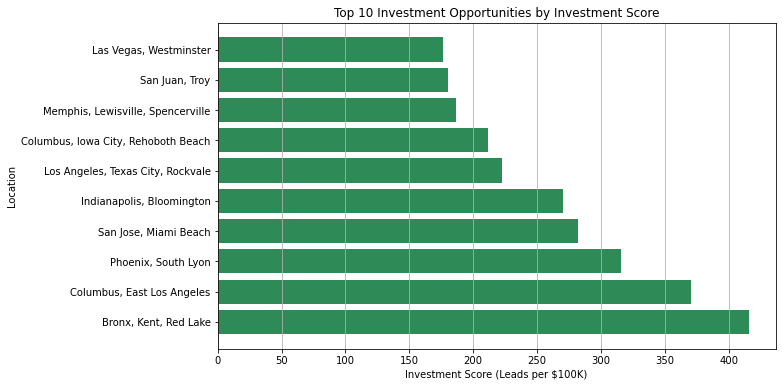

In [9]:
plt.figure(figsize=(10,6))
plt.barh(top_10_investments['Location'], top_10_investments['Investment Score'], color='seagreen')
plt.title('Top 10 Investment Opportunities by Investment Score')
plt.xlabel('Investment Score (Leads per $100K)')
plt.ylabel('Location')
plt.grid(axis='x')
plt.show()

## Task 3a: Select top 50 listings to promote

First, we filtered the data for for-sale listings, aggregated leads and searches by Location. Merged those insights into the listing-level inventory data and handled missing values. Finally, sort listings by most leads, then most searches, then lowest price and return the top 50 listings for promotion.

In [10]:
for_sale_df = inventory[inventory["Purpose"] == "for-sale"]

leads_by_location = leads.groupby("Location")["Leads"].sum().reset_index()
searches_by_location = traffic.groupby("Location")["Searches"].sum().reset_index()

for_sale_df = for_sale_df.merge(leads_by_location, on="Location", how="left")
for_sale_df = for_sale_df.merge(searches_by_location, on="Location", how="left")

for_sale_df[["Leads", "Searches"]] = for_sale_df[["Leads", "Searches"]].fillna(0)

top_1000 = for_sale_df.sort_values(by=["Leads", "Searches", "Price"], ascending=[False, False, True]).head(1000)
top_50 = top_1000.head(50)
print("\nTop 50 listings for promotion:")
print(top_50)


Top 50 listings for promotion:
      Listing iD   Purpose     Price  Bedroom Count Country           City  \
4920        6450  for-sale    742000              1      US  San Francisco   
2190        2796  for-sale   1100000              2      US  San Francisco   
6934        9284  for-sale   1400000              3      US  San Francisco   
7246        9722  for-sale  19676693              3      US      Manhattan   
367          468  for-sale    365000              0      US          Bronx   
4540        5942  for-sale    480000              0      US          Bronx   
365          465  for-sale    340000              1      US       San Juan   
2957        3824  for-sale    365000              1      US    Los Angeles   
7118        9541  for-sale    400000              1      US    Los Angeles   
3673        4765  for-sale    410000              1      US    Los Angeles   
248          318  for-sale    549999              1      US    Los Angeles   
964         1220  for-sale    68

### Plot the Top 50 Listings

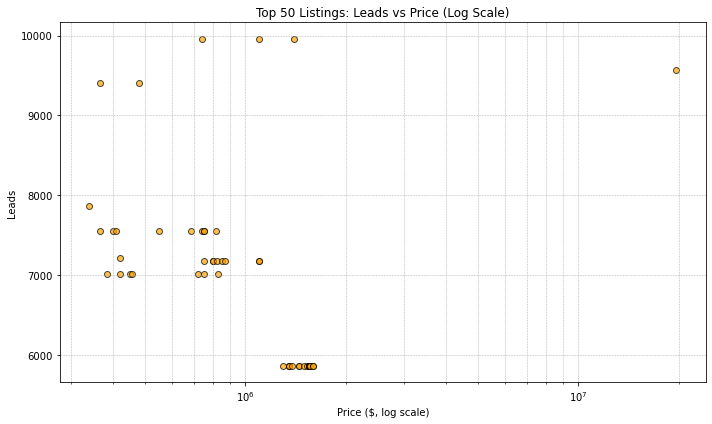

In [11]:
plt.figure(figsize=(10,6))
plt.scatter(top_50['Price'], top_50['Leads'], alpha=0.7, c='orange', edgecolors='k')
plt.xscale('log')  # Apply log scale
plt.title('Top 50 Listings: Leads vs Price (Log Scale)')
plt.xlabel('Price ($, log scale)')
plt.ylabel('Leads')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Task 3b: Define listings to remove from promotion

First, we compute the average price per Location. After that, we defined 3 rules for removing listings from the promotion pool: Listing shows no real intent, no visibility or it's likely overpriced for its market (Price > 1.5 × local avg). Finally, we combined the rules, filterd the listigns that should be removed and displayed the results.

In [12]:
top_1000["Avg Price in Location"] = top_1000.groupby("Location")["Price"].transform("mean")

rule_no_leads = top_1000["Leads"] == 0
rule_no_searches = top_1000["Searches"] == 0
rule_overpriced = top_1000["Price"] > (top_1000["Avg Price in Location"] * 1.5)

top_1000["Should_Remove"] = rule_no_leads | rule_no_searches | rule_overpriced

to_remove = top_1000[top_1000["Should_Remove"] == True]

print(f"\nNumber of listings that should be removed: {to_remove.shape[0]}")
print(to_remove[["Listing iD", "Location", "Price", "Leads", "Searches", "Avg Price in Location"]])



Number of listings that should be removed: 87
      Listing iD                             Location     Price   Leads  \
5533        7349  Columbus, Iowa City, Rehoboth Beach   3350000  5869.0   
1222        1543  Columbus, Iowa City, Rehoboth Beach   3399000  5869.0   
165          213                          Los Angeles  10000000  5511.0   
173          223                 Chicago, Centreville   2100000  5502.0   
914         1158                 Chicago, Centreville   2299000  5502.0   
...          ...                                  ...       ...     ...   
5180        6816              Chicago, Rogers, Molino    825000  1281.0   
2026        2586                   Chicago, Watertown    799000  1272.0   
3788        4932                     New York, Wausau   2690000  1262.0   
2349        3009                     New York, Wausau   2700000  1262.0   
3777        4918                   Chicago, Deer Park    660000  1256.0   

      Searches  Avg Price in Location  
5533      77

### Plot the Reasons for Removing Listings from Promotion

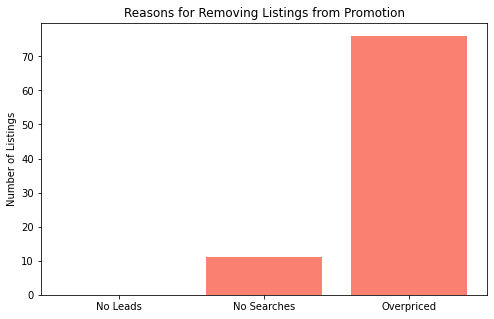

In [13]:
# Count reasons
remove_reasons = {
    'No Leads': (top_1000['Leads'] == 0).sum(),
    'No Searches': (top_1000['Searches'] == 0).sum(),
    'Overpriced': (top_1000['Price'] > top_1000['Avg Price in Location'] * 1.5).sum()
}

plt.figure(figsize=(8,5))
plt.bar(remove_reasons.keys(), remove_reasons.values(), color='salmon')
plt.title('Reasons for Removing Listings from Promotion')
plt.ylabel('Number of Listings')
plt.show()